In [2]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from tensorflow import keras
import tensorboard 
import keras.utils
from imageio import imread
import PIL
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
from skimage import color
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Convolution2D,BatchNormalization,Flatten,Dense,Dropout,MaxPool2D
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading dataset

In [3]:
dirList=os.listdir('/content/drive/MyDrive/flowers')
imageData=[]
imageLabel=[]
validExtensionsList=['jpg','tif','png','bmp']
for d in dirList:
   print('Processing...',d)
   for f in os.listdir('/content/drive/MyDrive/flowers/'+d):
        ext=f.split('.')[-1]
        if ext in validExtensionsList:
            data=imread('/content/drive/MyDrive/flowers/'+d+'/'+f)
            resized_data=resize(data,(100,100))
            imageData.append(resized_data)
            imageLabel.append(d)
        else:
            pass
print('DONE!')

Processing... rose
Processing... dandelion
Processing... tulip
Processing... daisy
Processing... sunflower
Processing... train
Processing... validation
DONE!


Finding GPU


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Checking the shape

In [5]:
np.shape(imageData),np.shape(imageLabel)

((4317, 100, 100, 3), (4317,))

Checking an random Image

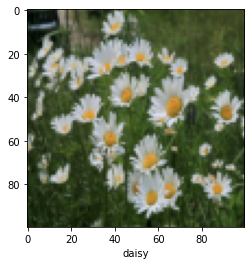

In [6]:
idx=np.random.randint(len(imageData))
plt.imshow(imageData[idx])
plt.xlabel(imageLabel[idx])
plt.show()

Changing the shape

In [7]:
X=np.array(imageData)
X=X.reshape(X.shape[0],X.shape[1],X.shape[2],3)
y=np.array(imageLabel)
num_classes=len(set(y))
le=LabelEncoder()
y=le.fit_transform(y)
y=to_categorical(num_classes=num_classes,y=y)
input_shape=(X.shape[1],X.shape[2],X.shape[3])

In [8]:
np.shape(X),np.shape(y)

((4317, 100, 100, 3), (4317, 5))

# VGG-13 Model

In [9]:
def createCNNModel():
    model=Sequential()
    model.add(Convolution2D(64,3,input_shape=input_shape,activation='relu'))
    model.add(Convolution2D(64,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    model.add(Convolution2D(128,3,input_shape=input_shape,activation='relu'))
    model.add(Convolution2D(128,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    model.add(Convolution2D(256,3,input_shape=input_shape,activation='relu'))
    model.add(Convolution2D(256,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    model.add(Convolution2D(512,3,input_shape=input_shape,activation='relu'))
    model.add(Convolution2D(512,3,input_shape=input_shape,activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.20))
    model.add(Flatten())
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(num_classes,activation='softmax'))
    return model
model=createCNNModel()
logdir= '/content/drive/MyDrive/flowers/'
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       7

# Splitting dataset into train, test, val

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
np.shape(X_train),np.shape(y_train),np.shape(X_test),np.shape(y_test),np.shape(X_val),np.shape(y_val)

((2762, 100, 100, 3),
 (2762, 5),
 (864, 100, 100, 3),
 (864, 5),
 (691, 100, 100, 3),
 (691, 5))

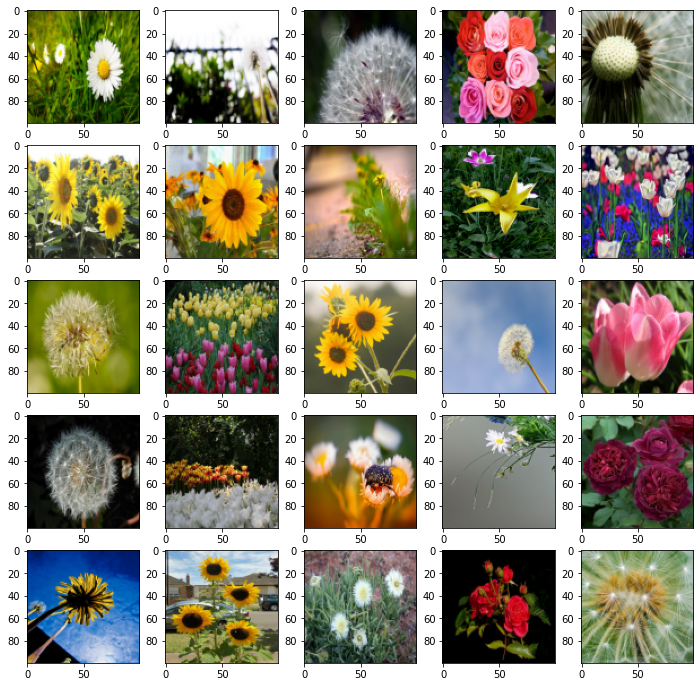

In [11]:
w=10
h=10
fig=plt.figure(figsize=(12,12))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(img))
plt.show()

# Preprosessing Image

In [12]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=True,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        #rotation_range=10,  
        #zoom_range = 0.1, 
       # width_shift_range=0.2, 
       # height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=True)
datagen.fit(X_train)

# Compiler

In [13]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['acc'])

# Trainning the model

In [18]:
history = model.fit(datagen.flow(X_train,y_train, batch_size = 64) ,epochs = 100 , validation_data = datagen.flow(X_val,y_val),callbacks=[tensorboard_callback])

Epoch 1/100
44/44 [==============================] - 13s 293ms/step - loss: 0.3171 - acc: 0.8802 - val_loss: 0.9163 - val_acc: 0.7381
Epoch 2/100
44/44 [==============================] - 13s 293ms/step - loss: 0.2999 - acc: 0.8838 - val_loss: 1.0126 - val_acc: 0.7120
Epoch 3/100
44/44 [==============================] - 13s 292ms/step - loss: 0.3217 - acc: 0.8892 - val_loss: 1.0878 - val_acc: 0.7091
Epoch 4/100
44/44 [==============================] - 13s 290ms/step - loss: 0.3137 - acc: 0.8856 - val_loss: 0.8704 - val_acc: 0.7352
Epoch 5/100
44/44 [==============================] - 13s 292ms/step - loss: 0.3144 - acc: 0.8820 - val_loss: 0.9898 - val_acc: 0.7250
Epoch 6/100
44/44 [==============================] - 13s 291ms/step - loss: 0.3125 - acc: 0.8838 - val_loss: 0.8766 - val_acc: 0.7366
Epoch 7/100
44/44 [==============================] - 13s 293ms/step - loss: 0.2651 - acc: 0.8990 - val_loss: 0.9102 - val_acc: 0.7554
Epoch 8/100
44/44 [==============================] - 13s 290ms

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

In [ ]:
#history=model.fit(datagen.flow(X_train, y_train,batch_size = 64),validation_data=(X_val,y_val), epochs=40)

Tensorboard for flow char

In [21]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/flowers/train/

# Plotting the graph

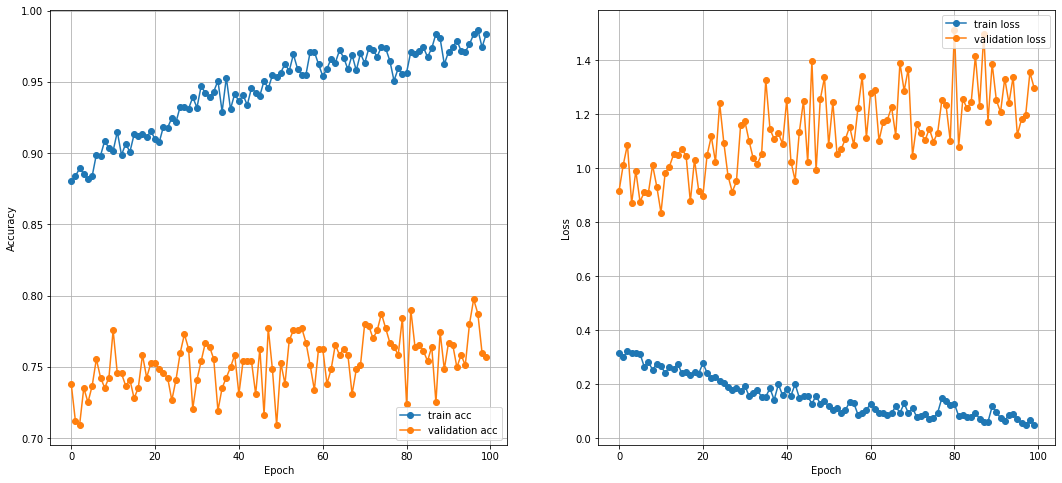

In [22]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], 'o-', label='train acc')
plt.plot(history.history['val_acc'], 'o-', label = 'validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [192]:
np.shape(y_test),np.shape(y_val),np.shape(y_train)

((864, 5), (691, 5), (2762, 5))

# Predicting a single image

Actual: 3  Predicted: 3


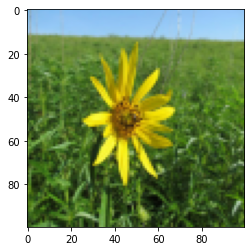

In [30]:
idxtest=np.random.randint(len(X_test))
testImg=X_test[idxtest]
plt.imshow(testImg,cmap='gray')
testImg=testImg.reshape(1,100,100,3)
pred=np.argmax(model.predict(testImg))
actual=np.argmax(y_test[idxtest])
print("Actual:",actual," Predicted:",pred)
plt.show()

In [195]:
predictions = model.predict(X_test)

In [31]:
layer = model.layers #1,5,6,10,11
filters,biases = model.layers[10].get_weights()
print(layer[10].name, filters.shape)

conv2d_4 (3, 3, 128, 256)


# Visulazing the filters

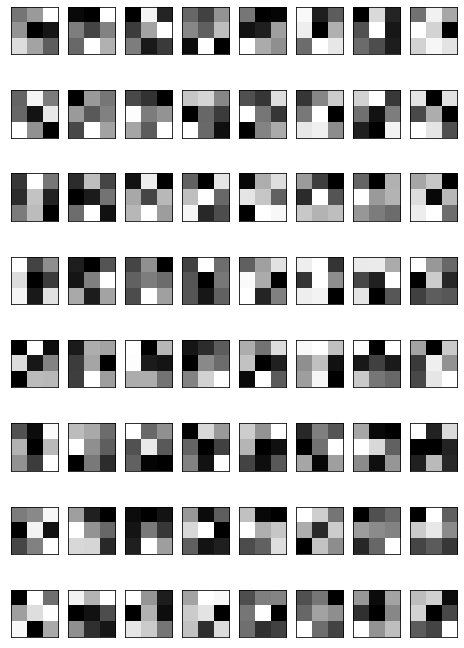

In [32]:
figl=plt.figure(figsize=(8,12))
columns=8
rows=8
n_filters=columns*rows
for i in range(1, n_filters+1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray')
plt.show()    

Create a shorter model

In [226]:
conv_layer_index = [1,5,6,10,11,15,16] #1,5,6,10,11
outputs = [model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=model.inputs, outputs=outputs)
print(model_short.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32_input (InputLayer  [(None, 100, 100, 3)]    0         
 )                                                               
                                                                 
 conv2d_32 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 conv2d_33 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                           

In [227]:
img = load_img('/content/drive/MyDrive/flowers/rose/10090824183_d02c613f10_m.jpg', target_size=(100,100))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
feature_output = model_short.predict(img)

# Visualization of the layers for a single image

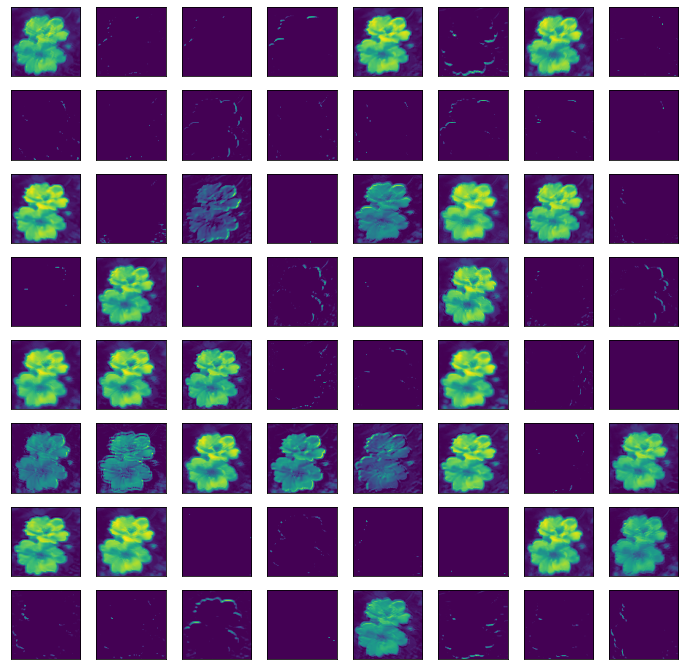

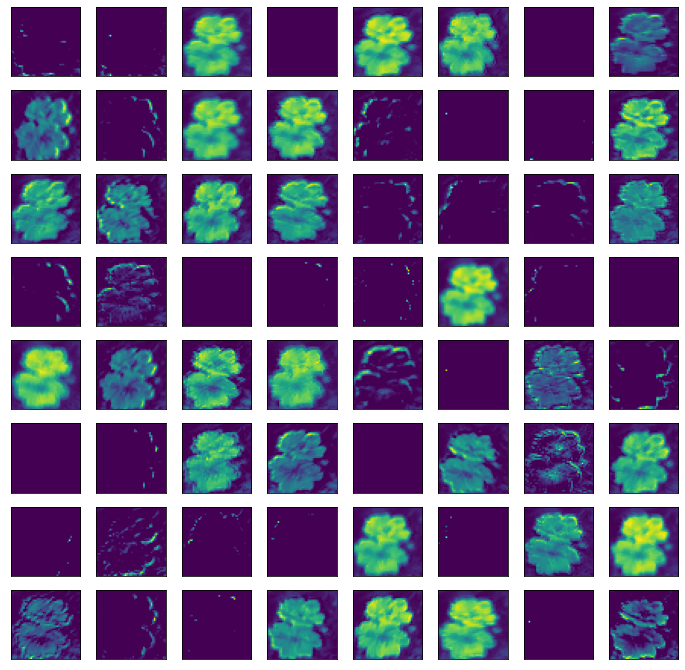

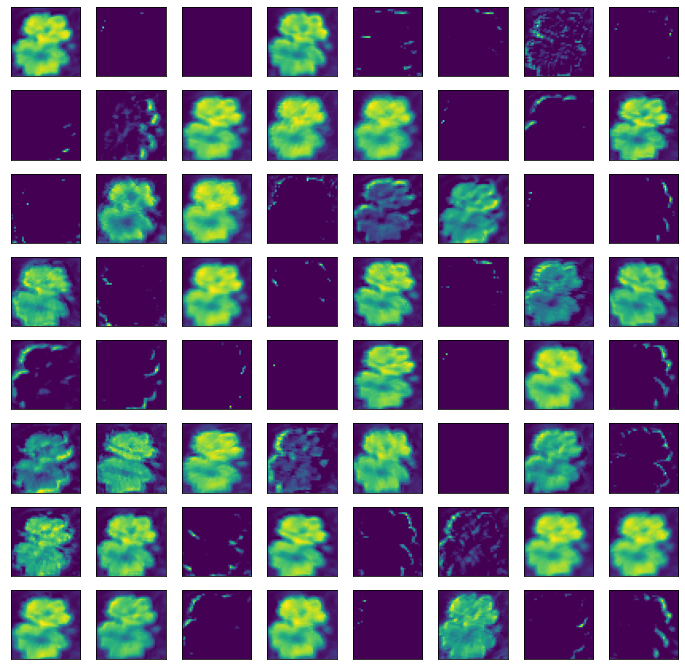

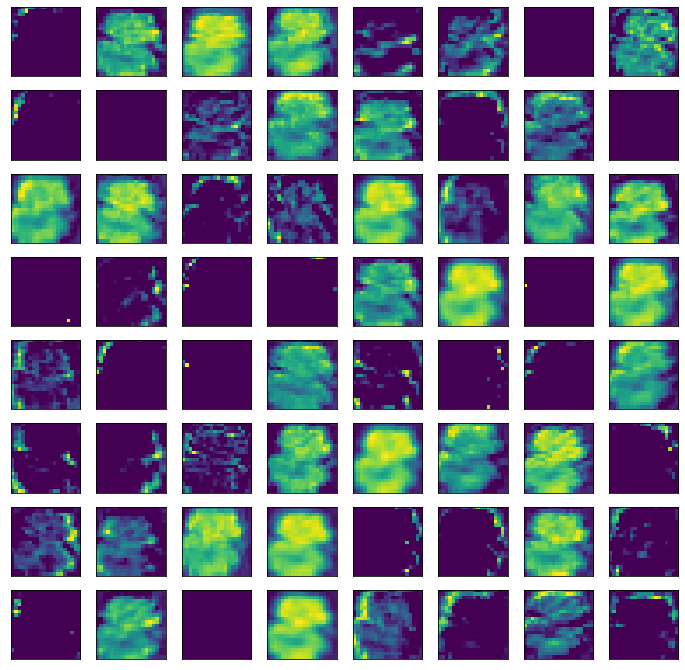

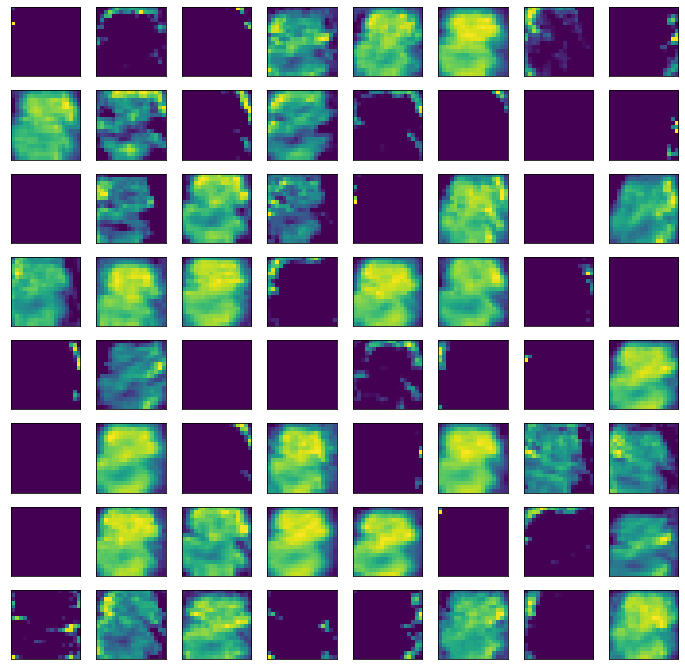

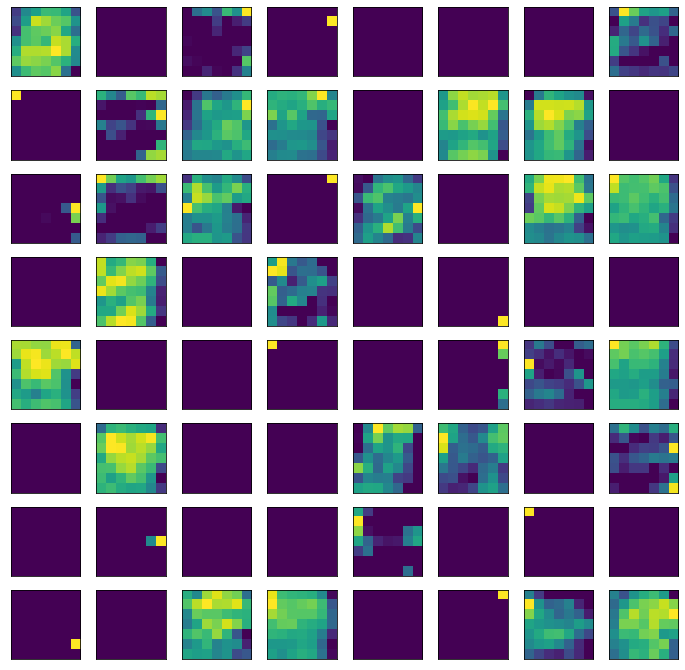

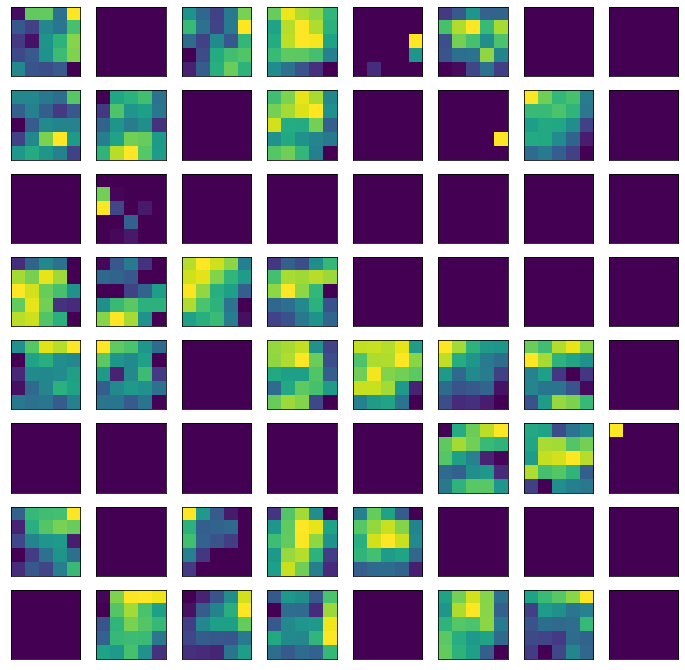

In [228]:
columns = 8
rows = 8
for ftr in feature_output:
    #pos = 1
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :,  i-1])
        #pos += 1
    plt.show()